In [1]:
from atari_irl import utils, encoding
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline
from baselines.ppo2 import ppo2
import joblib

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


Traceback (most recent call last):
  File "/home/aaron/rllab/rllab/envs/gym_env.py", line 9, in <module>
    from gym.wrappers.monitoring import logger as monitor_logger
ImportError: cannot import name 'logger'


In [2]:
tup = joblib.load('../scripts/experts/pong/irl_ablation_trained/caches/paths_50/full_cache_uint8.pkl')

Logging to /tmp/openai-2018-09-07-02-12-34-032732
Initial burn in 0/500: 36156.21484375
Initial burn in 100/500: 23150.857421875
Initial burn in 200/500: 23086.755859375
Initial burn in 300/500: 23047.296875
Initial burn in 400/500: 23044.98828125
Initial burn in 500/500: 23043.125
Initial burn in 600/500: 23039.1015625
Initial burn in 700/500: 23038.015625
Initial burn in 800/500: 23034.966796875
Initial burn in 900/500: 23034.615234375
Initial burn in 1000/500: 23036.21484375
Initial burn in 1100/500: 22946.45703125
Initial burn in 1200/500: 22899.509765625
Initial burn in 1300/500: 22888.232421875
Initial burn in 1400/500: 22879.5078125
Initial burn in 1500/500: 22876.01171875
Initial burn in 1600/500: 22873.64453125
Initial burn in 1700/500: 22872.09765625
Initial burn in 1800/500: 22879.490234375
Initial burn in 1900/500: 22877.029296875
Initial burn in 2000/500: 22875.224609375
Initial burn in 2100/500: 22873.517578125
Initial burn in 2200/500: 22872.76171875
Initial burn in 2300

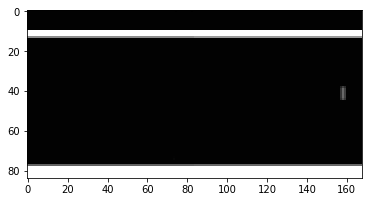

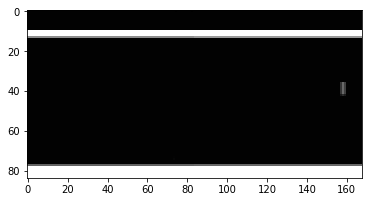

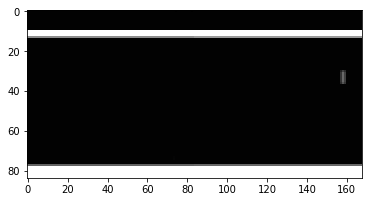

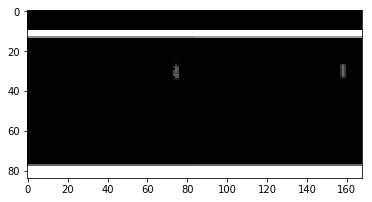

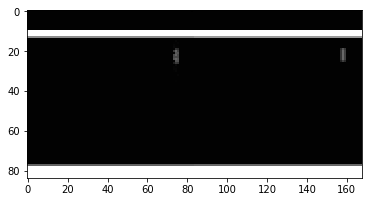

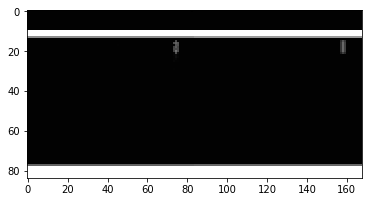

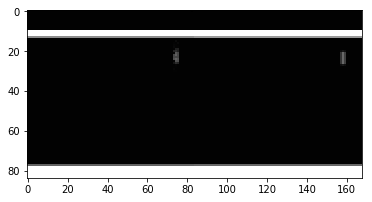

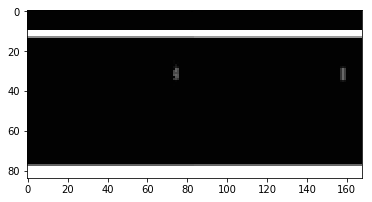

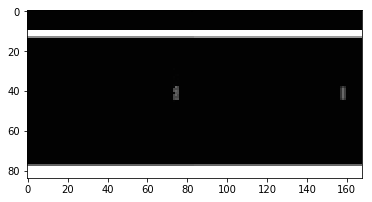

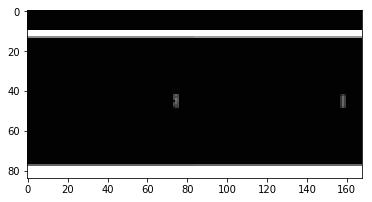

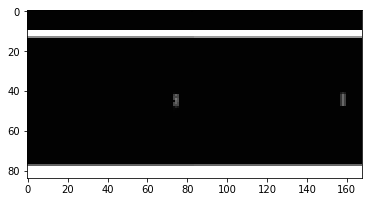

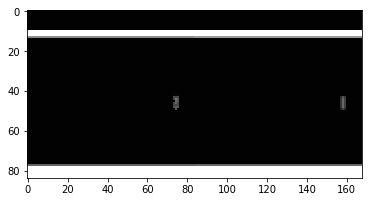

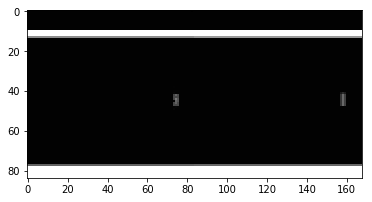

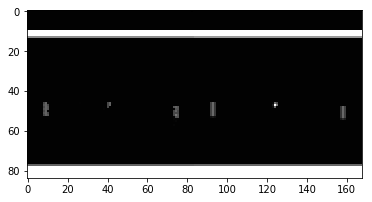

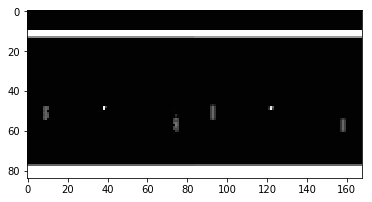

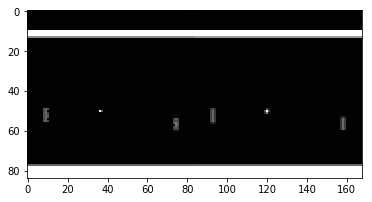

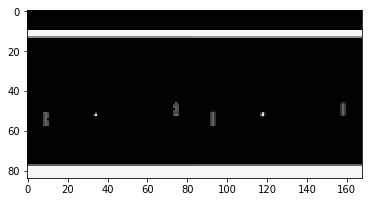

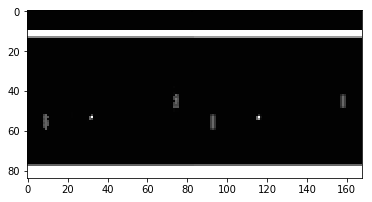

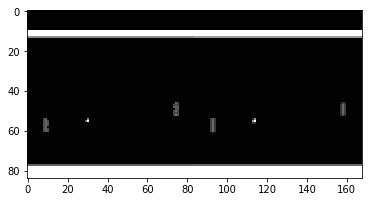

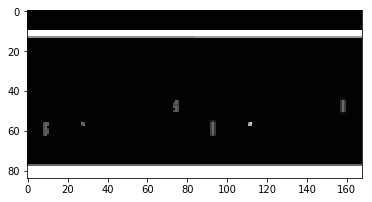

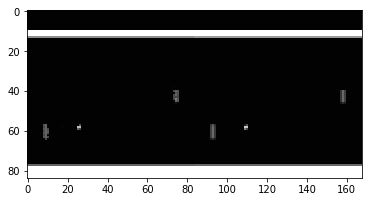

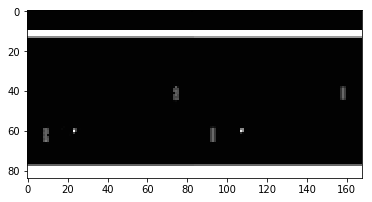

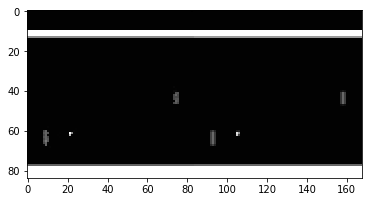

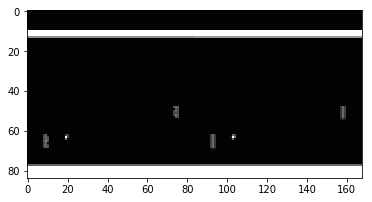

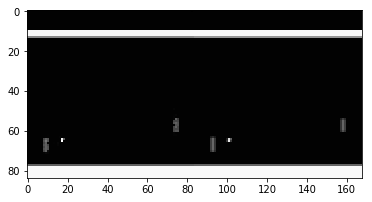

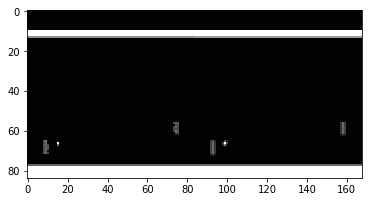

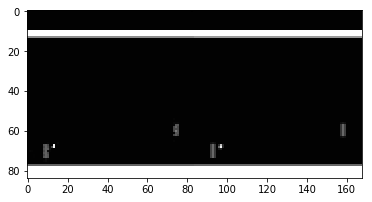

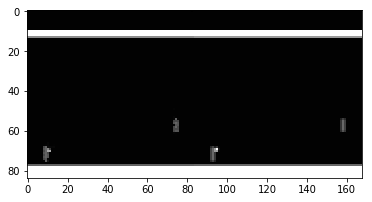

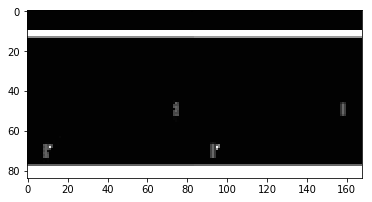

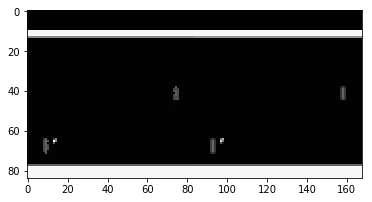

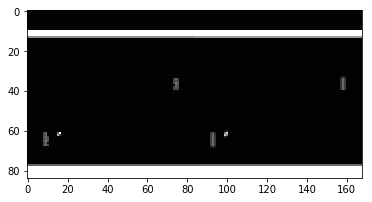

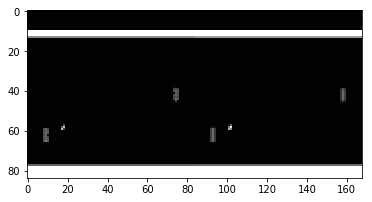

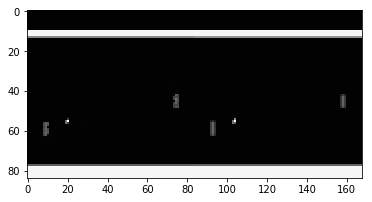

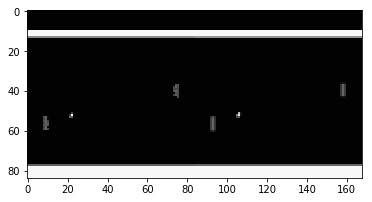

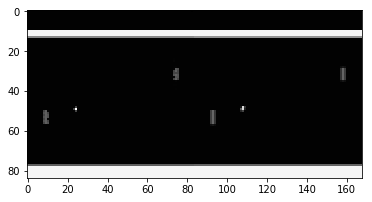

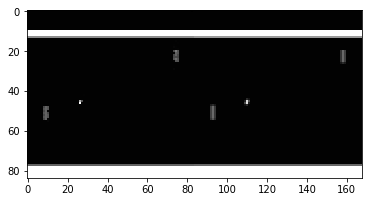

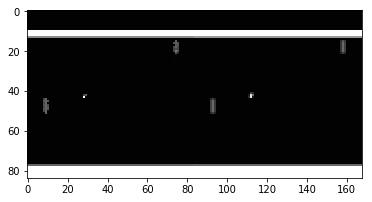

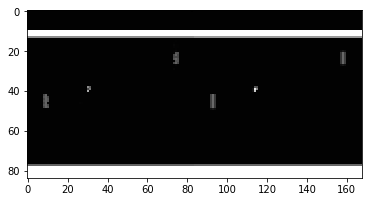

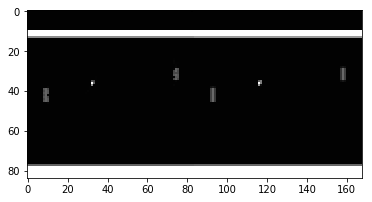

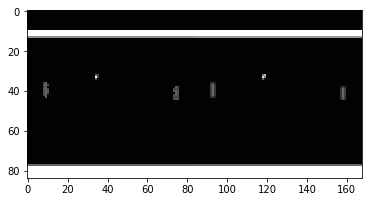

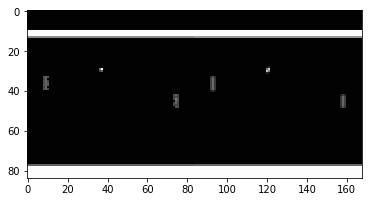

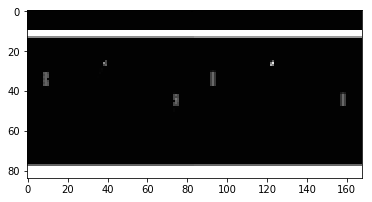

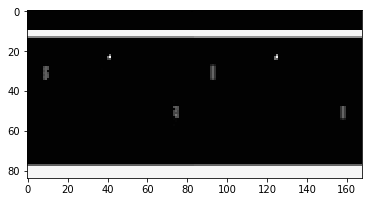

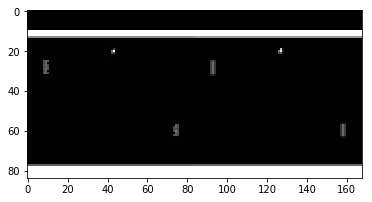

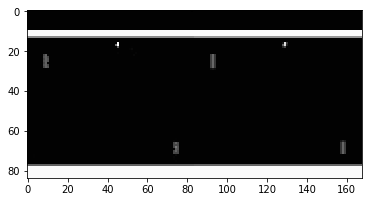

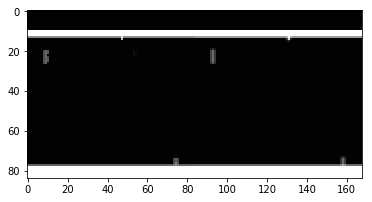

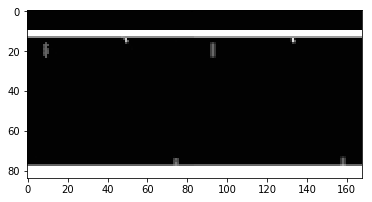

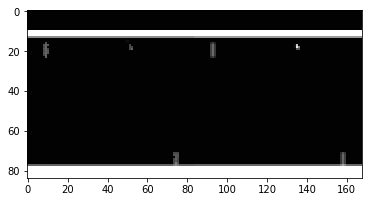

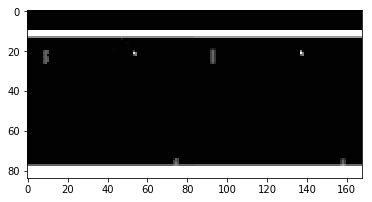

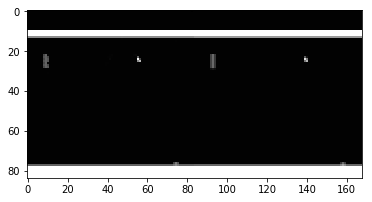

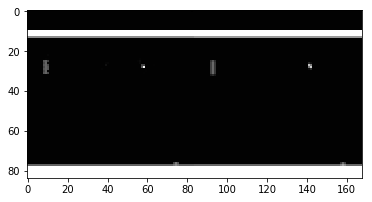

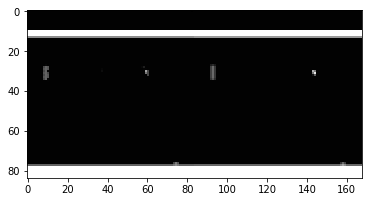

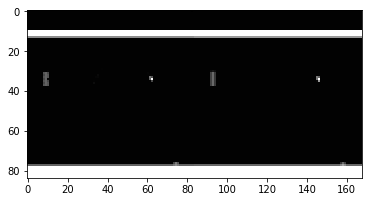

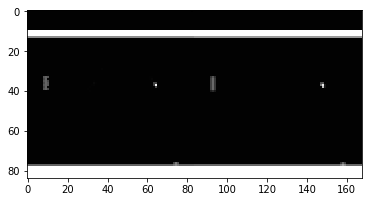

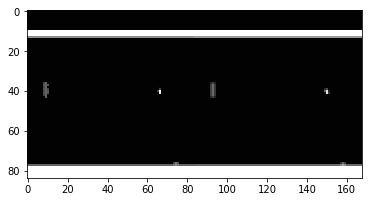

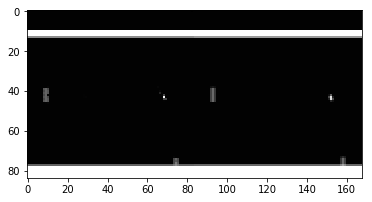

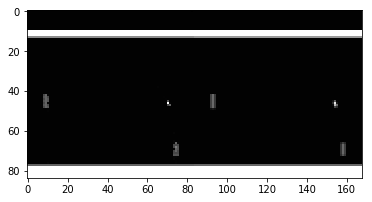

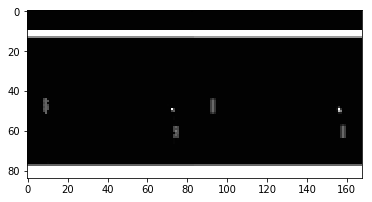

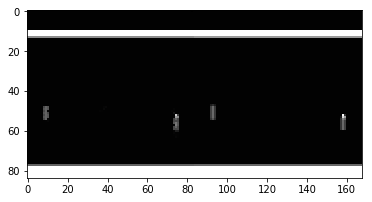

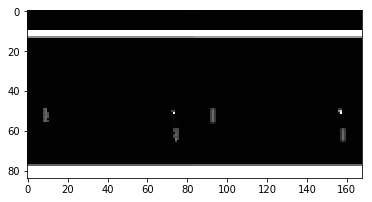

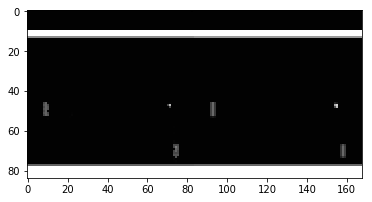

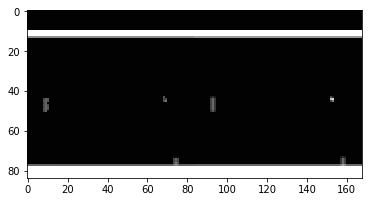

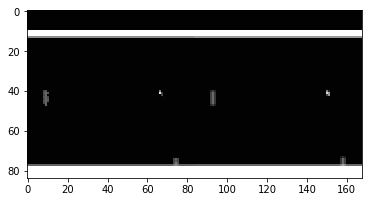

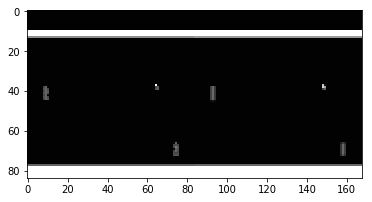

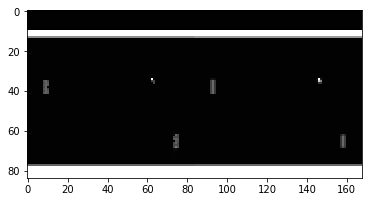

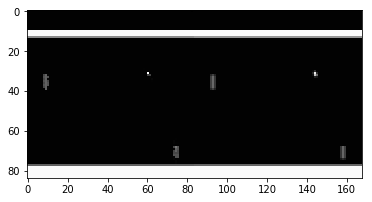

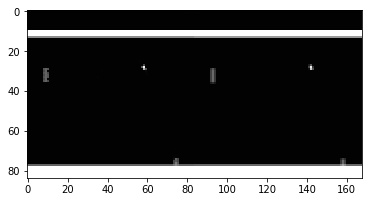

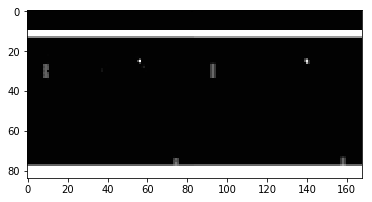

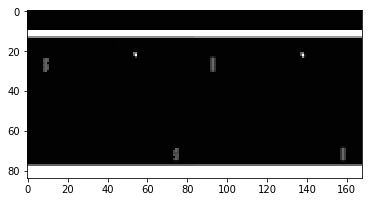

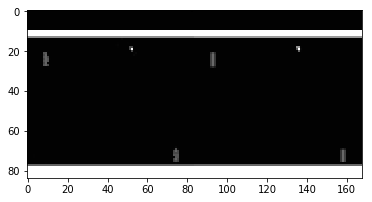

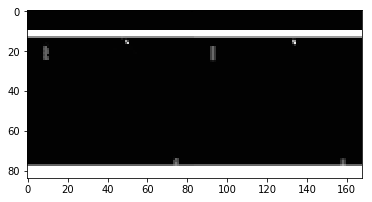

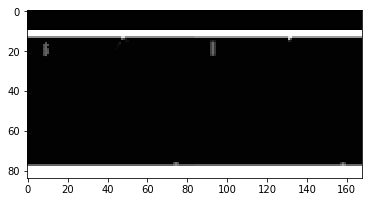

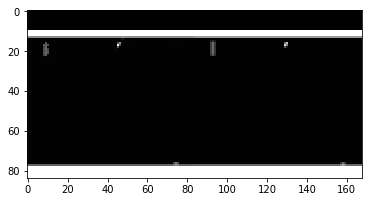

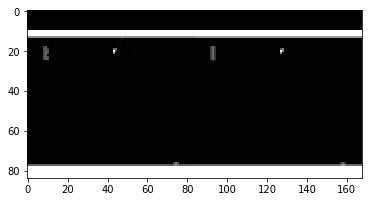

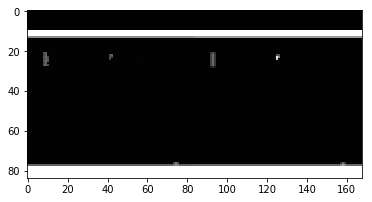

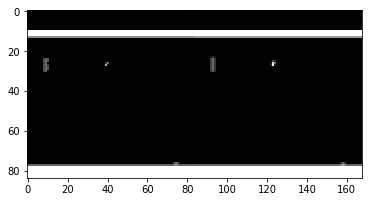

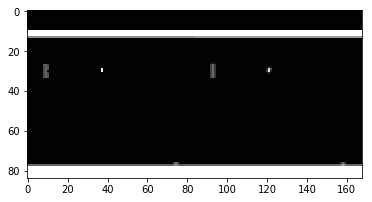

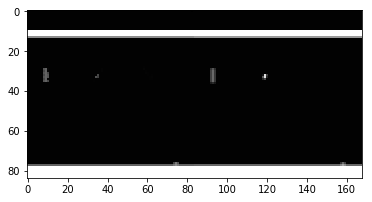

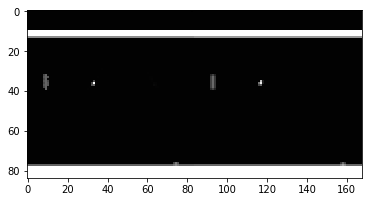

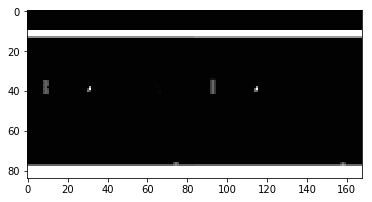

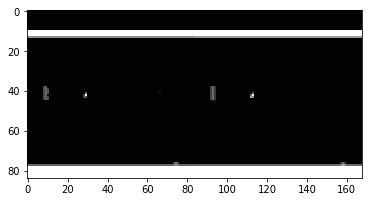

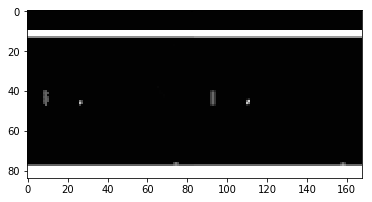

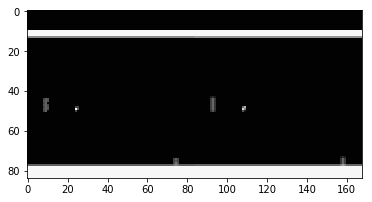

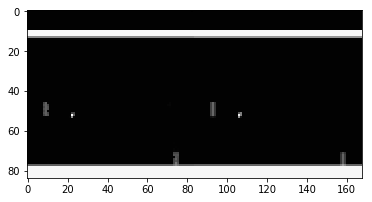

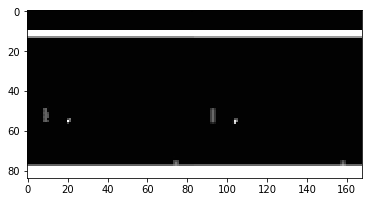

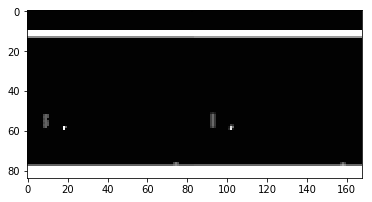

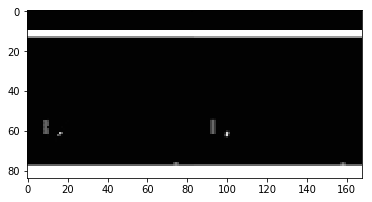

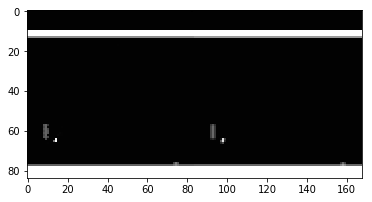

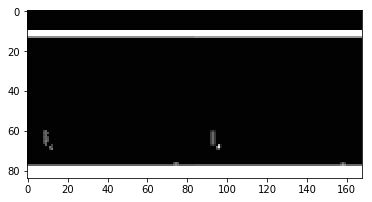

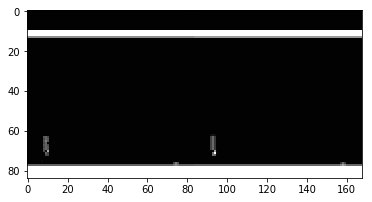

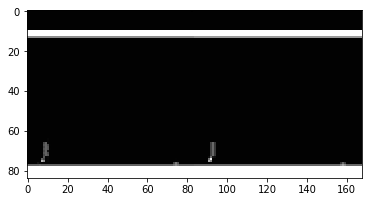

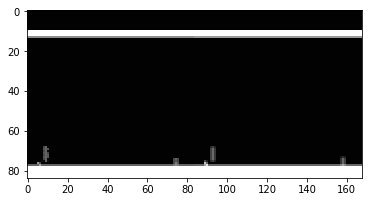

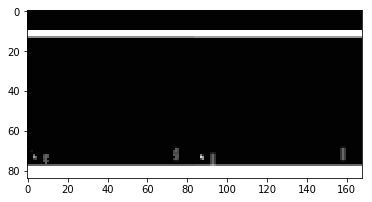

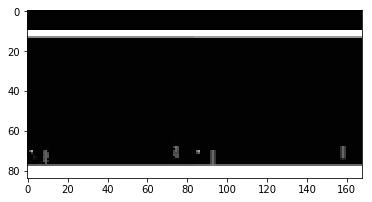

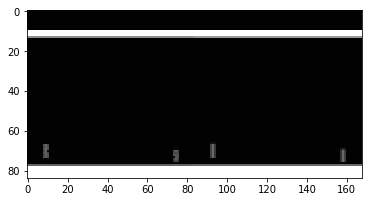

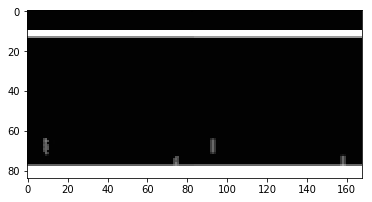

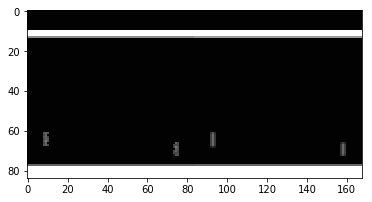

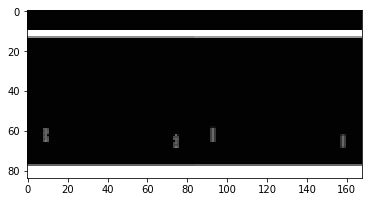

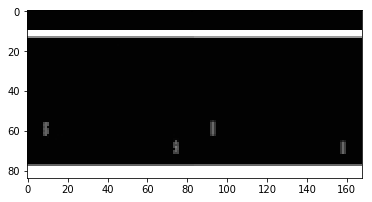

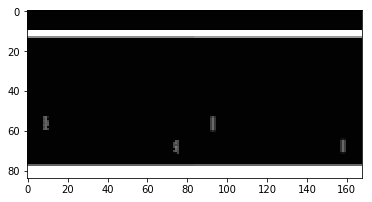

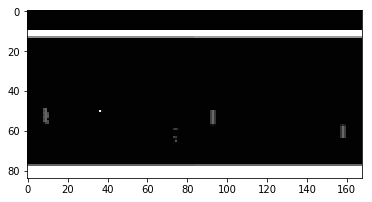

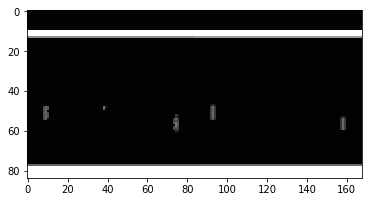

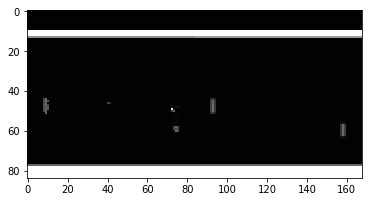

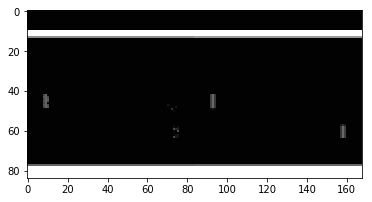

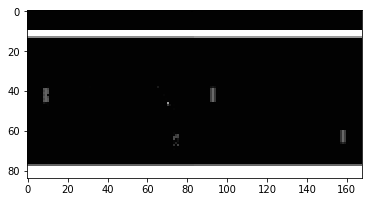

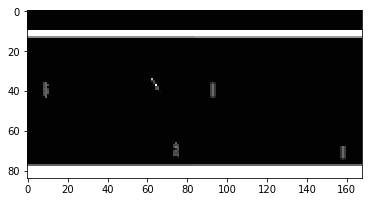

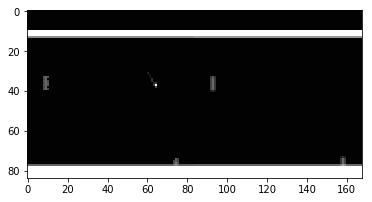

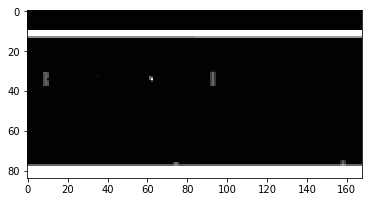

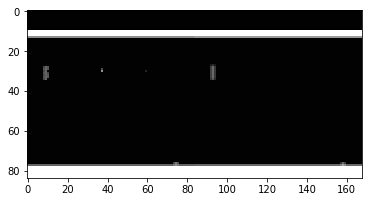

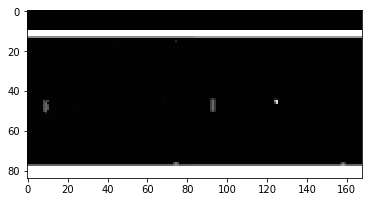

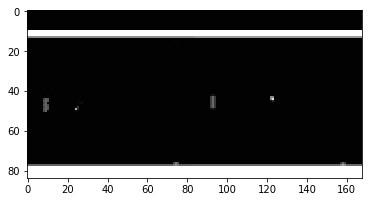

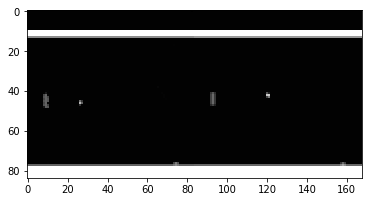

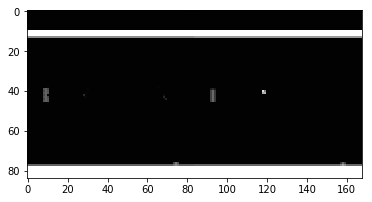

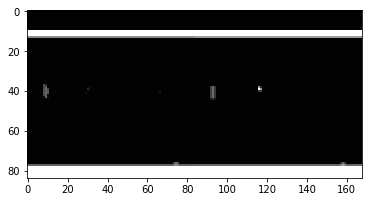

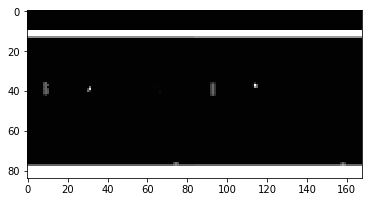

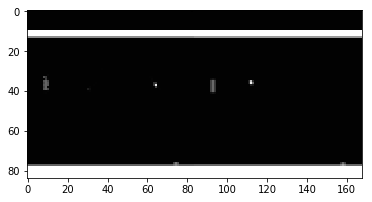

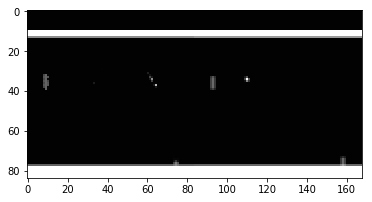

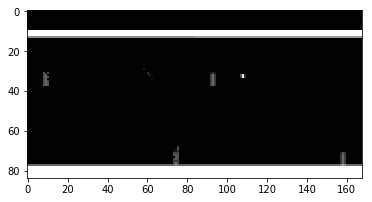

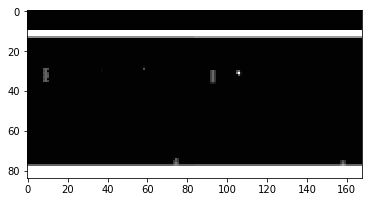

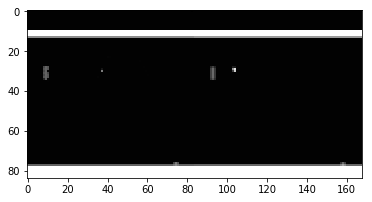

---------------------
| score | 23003.277 |
---------------------
---------------------
| score | 22996.166 |
---------------------
---------------------
| score | 22987.713 |
---------------------
---------------------
| score | 22981.918 |
---------------------
---------------------
| score | 22972.506 |
---------------------
---------------------
| score | 22966.328 |
---------------------
---------------------
| score | 22960.758 |
---------------------
---------------------
| score | 22952.271 |
---------------------
---------------------
| score | 22945.504 |
---------------------
---------------------
| score | 22937.447 |
---------------------
---------------------
| score | 22923.303 |
---------------------
---------------------
| score | 22920.334 |
---------------------
--------------------
| score | 22918.49 |
--------------------
---------------------
| score | 22919.865 |
---------------------
---------------------
| score | 22902.348 |
---------------------
-------------

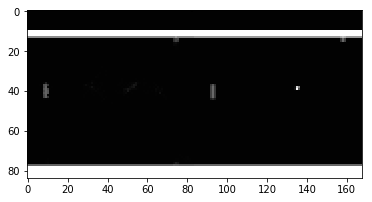

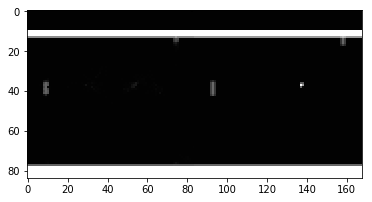

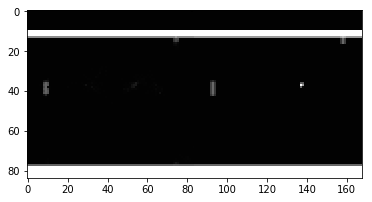

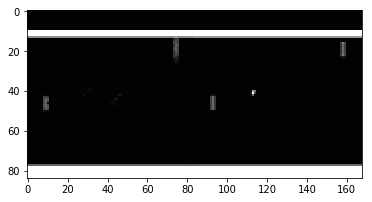

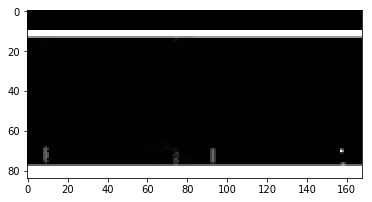

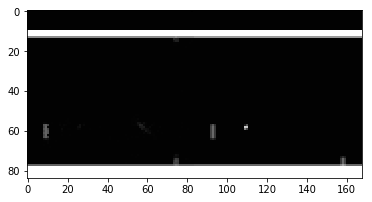

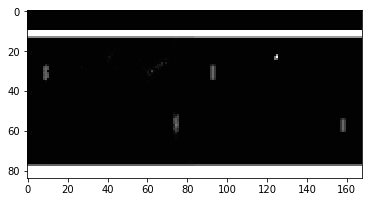

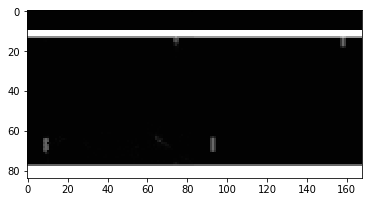

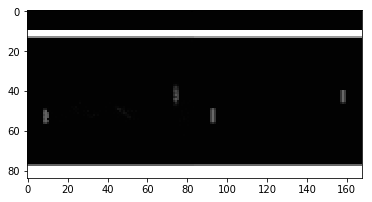

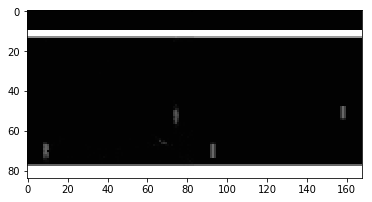

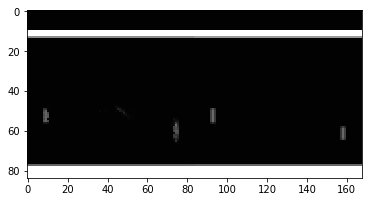

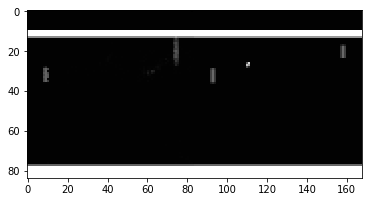

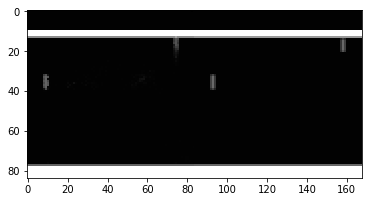

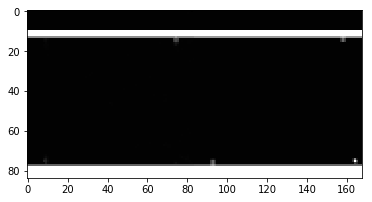

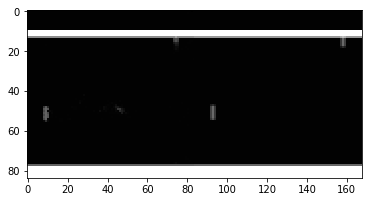

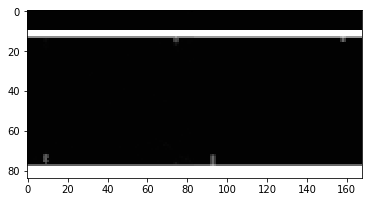

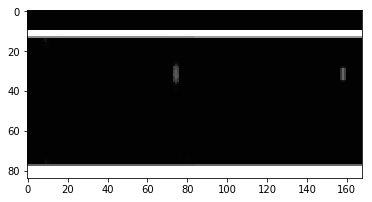

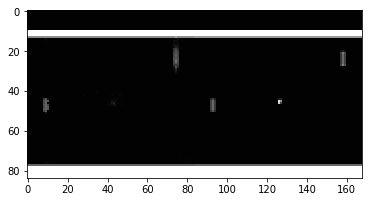

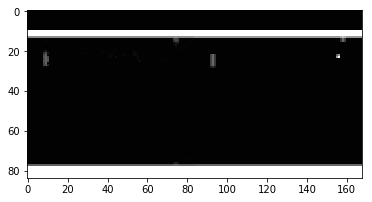

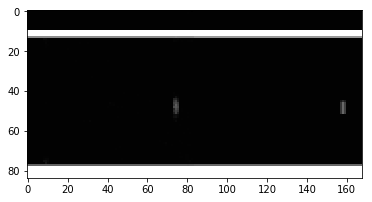

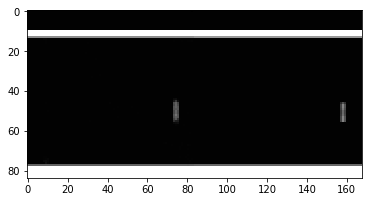

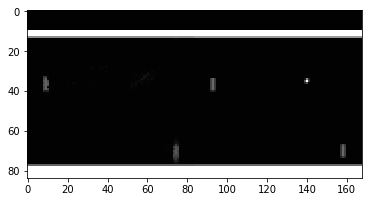

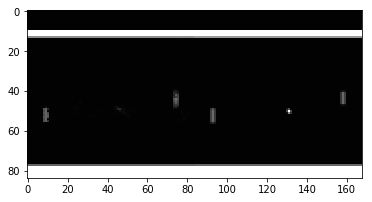

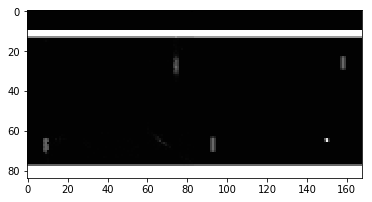

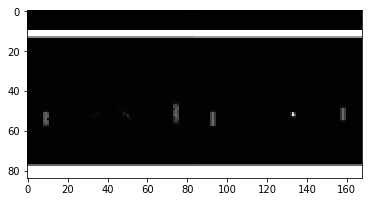

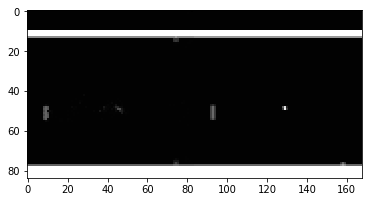

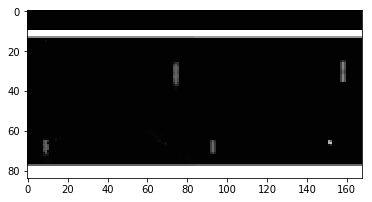

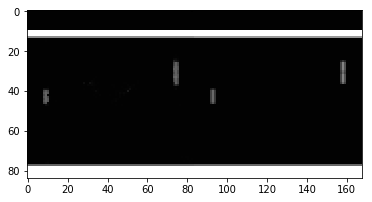

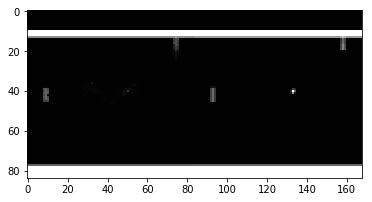

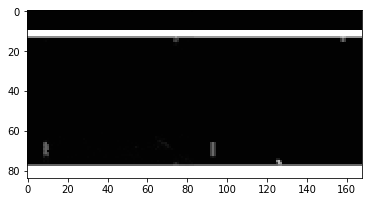

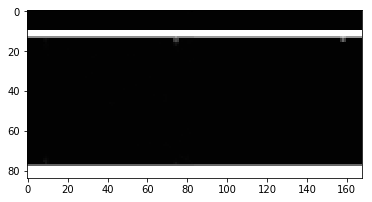

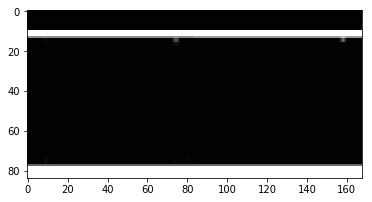

Process Process-4:
Process Process-2:
Process Process-1:
Process Process-7:
Process Process-8:
Process Process-6:
Process Process-3:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/aaron/anaconda3/envs/atari-irl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/aaron/anaconda3/envs/atari-irl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/aaron/anaconda3/envs/atari-irl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/aaron/anaconda3/envs/atari-irl/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/aaron/anaconda3/envs/atari-irl/lib/python3.6/multiprocessi

BrokenPipeError: [Errno 32] Broken pipe

In [3]:
tf_cfg = tf.ConfigProto(
    allow_soft_placement=True,
    intra_op_parallelism_threads=8,
    inter_op_parallelism_threads=8,
    device_count={'GPU': 1},
    log_device_placement=False
)
tf_cfg.gpu_options.allow_growth = True

env_cfg = {
    'env_name': 'PongNoFrameskip-v4',
    'n_envs': 8,
    'seed': 32,
    'one_hot_code': False
}

with utils.TfEnvContext(tf_cfg, env_cfg) as context:
    utils.logger.configure()
    vae = encoding.VariationalAutoEncoder(
        obs_shape=context.env_context.environments.observation_space.shape,
        d_classes=20,
        d_embedding=40,
        embedding_weight=0
    )
    LR = 1e-4
    
    def args(*, lr, obs):
        return {
            'lr': lr,
            'obs': obs,
            'noise': np.random.randn(obs.shape[0], vae.d_embedding) * .01
        }

    tf.get_default_session().run(tf.local_variables_initializer())
    tf.get_default_session().run(tf.global_variables_initializer())

    buffer = deque(maxlen=500)

    env = context.env_context.environments
    env.reset()
    num_timesteps = 10000
    for i in range(num_timesteps):
        lr = LR * (num_timesteps - i) * 1.0 / num_timesteps
        obs = []
        for t in range(256):
            acts = [env.action_space.sample() for _ in range(env.num_envs)]
            obs.append(env.step(acts)[0])
            
        obs = np.array(obs).astype(np.uint8)
        obs[:, :, :10, :, :] = 87.0
        obs_batch = ppo2.sf01(obs)

        if i == 0:
            initial_obs = tup[0][:120]
            initial_obs[:, :10, :, :] = 87.0
            #initial_obs = obs[:, 0, :, :, :]
            for n in range(5000):
                loss = vae.train_step(**args(lr=2.5e-4, obs=initial_obs[:100]))
                if n % 100 == 0:
                    print(f"Initial burn in {n}/500: {loss}")
            for i in range(120):
                plt.imshow(vae.compare(initial_obs[i:i+1], disp_p=1), cmap='gray')
                plt.show()

        if i % 100 == 0:
            for i in range(len(obs_batch)-1):
                if np.random.random() < .01:
                    plt.imshow(vae.compare(obs_batch[i:i+1], disp_p=1), cmap='gray')
                    plt.show()
            for epoch in range(4):
                for idx in np.random.permutation([i for i in range(len(buffer))]):
                    vae.train_step(lr=lr, obs=buffer[idx])
            if i < 1000 or i % 1000 == 0:
                vae.save(osp.join(utils.logger.get_dir(), f'vae_{i}.pkl'))

        buffer.append(obs_batch)
        utils.logger.logkv(
            'score',
            vae.train_step(**args(lr=lr, obs=buffer[np.random.randint(len(buffer))]))
        )

        utils.logger.dumpkvs()